# survival.ipynb
Survival analyses on the pedpancan cohort.

## TODO
- add extent of resection, sex, age as covariates in cox models
- add tumor purity, ibid. (@Rishaan)
- make a publication-ready plot
- Expand cohort:
    - SJ RTCG
    - Cancer research UK

In [20]:
library(tidyverse)
library(readxl)
library(dplyr)
library(stringr)
library(naniar) #for replace with Nas function
library(survival)
library(survminer)
library(RColorBrewer)
library(janitor)
library(rio)
#library(labelled)
library(gt)
library(gtsummary)
library(ggsurvfit)
library(extrafont)
library(svglite)
install.packages("devtools")
library(devtools)
devtools::install_github("MSKCC-Epi-Bio/bstfun")
pacman::p_load(bstfun)

extrafont::font_import(pattern="Arial",prompt=FALSE)
extrafont::loadfonts()

sessionInfo()

also installing the dependencies ‘zip’, ‘httpuv’, ‘sourcetools’, ‘later’, ‘promises’, ‘diffobj’, ‘gert’, ‘shiny’, ‘downlit’, ‘brio’, ‘waldo’, ‘usethis’, ‘miniUI’, ‘pkgdown’, ‘profvis’, ‘roxygen2’, ‘testthat’


Warning message in install.packages("devtools"):
“installation of package ‘zip’ had non-zero exit status”
Warning message in install.packages("devtools"):
“installation of package ‘sourcetools’ had non-zero exit status”
Warning message in install.packages("devtools"):
“installation of package ‘later’ had non-zero exit status”
Warning message in install.packages("devtools"):
“installation of package ‘diffobj’ had non-zero exit status”
Warning message in install.packages("devtools"):
“installation of package ‘brio’ had non-zero exit status”
Warning message in install.packages("devtools"):
“installation of package ‘profvis’ had non-zero exit status”
Warning message in install.packages("devtools"):
“installation of package ‘roxygen2’ had non-zero exit status”
Warning message in insta

ERROR: Error in library(devtools): there is no package called ‘devtools’


In [2]:
## OSC create an output directory if it doesn't exist
dir.create('../out', showWarnings = FALSE)

load_survival_data <- function(path, tumor_types=NULL){
  ## path: path to data/Supplementary Tables.xlsx
  ## tumor_types: (optional) may specify only a subset of tumor types present in the dataset.
  combinedsurv <- read_excel(path, sheet="1. Patients")
  # Subset for tumor types if specified
  if (!is.null(tumor_types)){
    combinedsurv <- combinedsurv %>%
    filter(str_detect(cancer_type, tumor_types))
  }

  # Drop NAs
  combinedsurv <- combinedsurv %>%
    filter(complete.cases(amplicon_class,OS_status,OS_months)) %>%
    mutate(OS_months = as.numeric(OS_months)) %>%
  # Censor at 5 years = 60 months
    mutate(OS_months_5y = if_else(OS_months < 60, OS_months, 60)) %>%
    mutate(OS_status_5y = if_else(OS_months <= 60, OS_status, "Alive")) %>%
    mutate(OS_status_5y = if_else(OS_status_5y == "Alive", 0, 1)) %>%
  # get ecDNA status
    mutate(ecDNA_status = if_else(amplicon_class == "ecDNA", "ecDNA+", "ecDNA-")) %>%
  # convert to factors
    mutate(ecDNA_status = factor(ecDNA_status)) %>%
    mutate(amplicon_class = factor(amplicon_class)) %>%
    mutate(cancer_type = factor(cancer_type))
    
  return(combinedsurv)
}

cox_plot <- function(data,outfile){
  ## OSC function to perform a Cox regression and generate the plot
  coxph(Surv(OS_months, OS_status) ~ ecDNA_status + strata(cancer_type), data = data)
}

km_plot <- function(survObj,outfile=NULL){
  ## OSC function to perform a KM analysis and generate the plot
  if (length(survObj$n) == 2){
    colors = c('blue', 'red')
    labels = c('ecDNA-', 'ecDNA+')
  } else if (length(survObj$n) == 3){
    colors = c('red','magenta','dodgerblue')
    labels = c('ecDNA','intrachromosomal','no amplification')
  }
  plt <- survObj %>% 
   ggsurvfit(linewidth=0.5) +
   labs(x = 'Follow-up time (Months)',
        y = 'Overall Survival') +
   scale_color_manual(values = colors,
                      labels = labels) +
   scale_fill_manual(values = colors,
                     labels = labels) +
   scale_y_continuous(limits=c(0, 1))+
   add_censor_mark(size = .5, alpha = 1) +
   add_risktable(risktable_stats = "n.risk", size=2,
                 theme = theme_risktable_default(axis.text.y.size = 7,
                                    plot.title.size = 7)) +
   add_risktable_strata_symbol(size=4) + 
   theme_classic(base_size=7, base_family="Arial",) +
   theme(axis.text = element_text(size=7,colour="black"),
         legend.position = "bottom",
   )
  if (length(survObj$n) <=3){
    plt <- plt + add_confidence_interval()
  }
  
  if(!is.null(outfile)){
    pdf.options(encoding='ISOLatin2.enc')
    pdfName = paste(outfile, ".pdf", sep="")
    pngName = paste(outfile, ".png", sep="")
    svgName = paste(outfile, ".svg", sep = "")
    ggsave(path="out", filename=pdfName, device="pdf", width=3, height=3.5, units='in')
    ggsave(path="out", device="png", filename=pngName, width=3, height=3.5, units='in')
    ggsave(path="out", device="svg", filename=svgName, width=3, height=3.5, units='in')
  }
  return(plt)
}

# Kaplan-Meier regressions

[1] "/Users/sunitasridhar/Desktop/Research_Project/GitHub/2024-07-17_survival"


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”


Call:
survdiff(formula = formula, data = data)

                       N Observed Expected (O-E)^2/E (O-E)^2/V
ecDNA_status=ecDNA- 2054      359    427.8      11.1       139
ecDNA_status=ecDNA+  211      106     37.2     127.5       139

 Chisq= 139  on 1 degrees of freedom, p= <2e-16 

[1] 2265   12

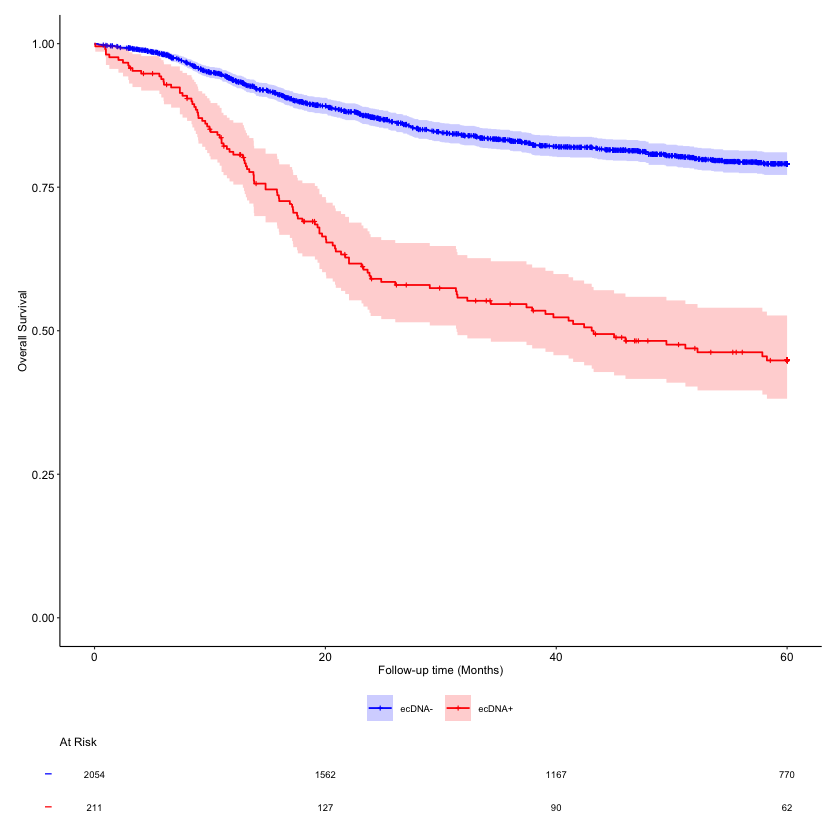

In [3]:
# KM by ecDNA status of combined cohort, censored at 5 years
#no filters applied by cancer type or n value
print(getwd())
data <- load_survival_data("../data/Supplementary Tables 12_1_24.xlsx")
formula <- Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status
km <- survfit2(formula=formula, data=data)
km_plot(km)
#km_plot(km, "km_surv_all_5year")
logrank <- survdiff(formula,data)
logrank
dim(data)

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label


	Pairwise comparisons using Log-Rank test 

data:  data and amplicon_class 

                 ecDNA   intrachromosomal
intrachromosomal 0.00022 -               
no amplification < 2e-16 7.3e-09         

P value adjustment method: BH 

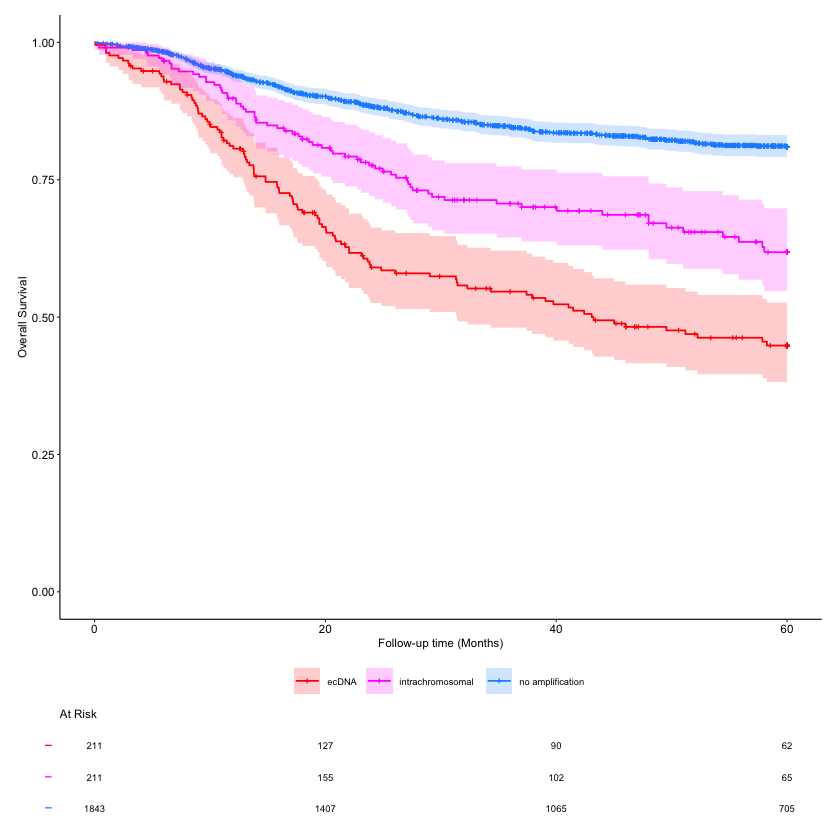

In [4]:
# KM by amplicon typeclass_map
# no filters applied by amplicon type or n value
data <- load_survival_data("../data/Supplementary Tables 12_1_24.xlsx") #%>%
  #mutate(amplicon_class = recode(amplicon_class))
formula <- Surv(OS_months_5y, OS_status_5y) ~ amplicon_class
km <- survfit2(formula=formula, data=data)
km_plot(km)
#km_plot(km, "km_class_all_5year")
logrank <- pairwise_survdiff(formula,data,p.adjust.method="BH",rho=0)
logrank

[1] LGG  GCT  EPN  MBL  CPG  HGG  PNST MEL  CPT  EMBT SARC PINT NBL  RMS  OST 
[16] WLM 
16 Levels: CPG CPT EMBT EPN GCT HGG LGG MBL MEL NBL OST PINT PNST RMS ... WLM

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”


Call:
survdiff(formula = formula, data = dd2)

                       N Observed Expected (O-E)^2/E (O-E)^2/V
ecDNA_status=ecDNA- 1622      301    364.6      11.1       119
ecDNA_status=ecDNA+  198      101     37.4     107.9       119

 Chisq= 119  on 1 degrees of freedom, p= <2e-16 

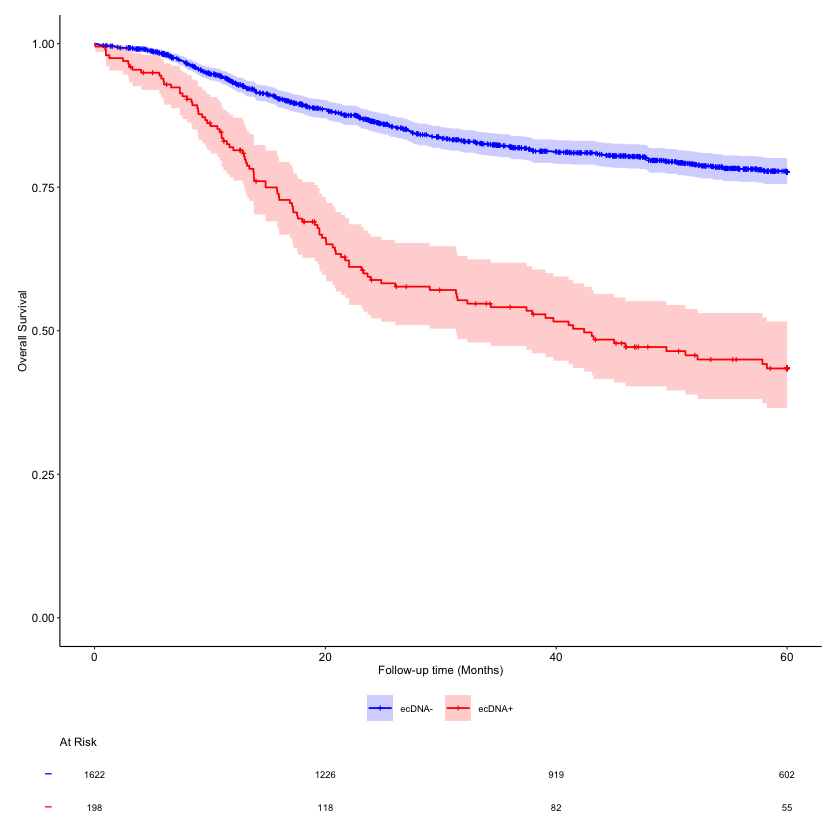

In [7]:
# KM by ecDNA status of tumor types with at least 1 sample with ecDNA, censored at 5 years
#filtered by tumor type with ecDNA, n > 10 and at least one patient who is deceased
dd2 <- load_survival_data("../data/Supplementary Tables 12_1_24.xlsx") %>%
  group_by(cancer_type) %>%
  filter(any(amplicon_class == 'ecDNA')) %>%
  filter(n() >= 10) %>%
  filter (any(OS_status == 'Deceased'))%>%
  ungroup()
dd2$cancer_type <- droplevels(dd2$cancer_type) # drop unused levels
dd2$cancer_type %>% unique() # print remaining levels

formula <- Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status
km <- survfit2(formula=formula, data=dd2)
km_plot(km)
#km_plot(km, "km_surv_subset_5year")
logrank <- survdiff(formula,dd2)
logrank


[1] LGG  GCT  EPN  MBL  CPG  HGG  PNST MEL  CPT  EMBT SARC PINT NBL  RMS  OST 
[16] WLM 
16 Levels: CPG CPT EMBT EPN GCT HGG LGG MBL MEL NBL OST PINT PNST RMS ... WLM

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label


	Pairwise comparisons using Log-Rank test 

data:  dd2 and amplicon_class 

                 ecDNA   intrachromosomal
intrachromosomal 0.00022 -               
no amplification < 2e-16 1.1e-07         

P value adjustment method: BH 

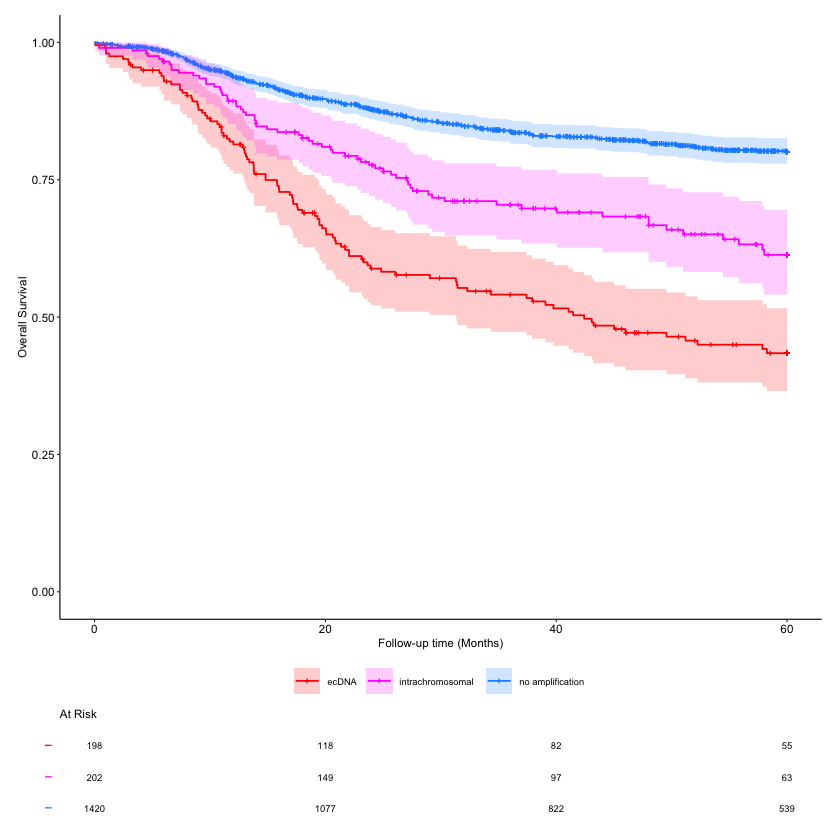

In [6]:
# KM with just the SJ samples that had survival data added 
#(seems to have bug where WLM tumor is annotated?
# KM by ecDNA status of tumor types with at least 1 sample with ecDNA, censored at 5 years
dd2 <- load_survival_data("../data/Supplementary Tables 12_1_24.xlsx") %>%
  group_by(cancer_type) %>%
  filter(n() >= 10) %>%
  filter (any(OS_status == 'Deceased'))%>%
  filter(any(amplicon_class == 'ecDNA'))%>%
  ungroup()
dd2$cancer_type <- droplevels(dd2$cancer_type) # drop unused levels
dd2$cancer_type %>% unique() # print remaining levels

formula = Surv(OS_months_5y, OS_status_5y) ~ amplicon_class
km = survfit2(formula=formula, data = dd2 )
#km_plot(km, "km_class_subset_5year")
km_plot(km)
logrank <- pairwise_survdiff(formula,dd2,p.adjust.method="BH",rho=0)
logrank



In [99]:
head(dd2)
write_csv(dd2, "/Users/sunitasridhar/Desktop/patients_sunita.csv")
#dd2.to_csv("/Users/sunitasridhar/Desktop/patients_sunita.csv")

patient_id,sex,age_at_diagnosis,cohort,cancer_type,cancer_subclass,amplicon_class,OS_status,OS_months,OS_months_5y,OS_status_5y,ecDNA_status
<chr>,<chr>,<dbl>,<chr>,<fct>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
PT_02J5CWN5,Male,3722,PBTA-X00,LGG,MAPK,no amplification,Deceased,96.821355,60.000000,0,ecDNA-
PT_02QZ7Z0H,Male,632,PBTA-X01,GCT,TT,no amplification,Alive,62.718686,60.000000,0,ecDNA-
PT_0449KSQ3,Female,3900,PBTA-X01,LGG,NOS,no amplification,Alive,21.650924,21.650924,0,ecDNA-
PT_04V47WFC,Male,6710,PBTA-X01,EPN,NOS,no amplification,Deceased,49.379877,49.379877,1,ecDNA-
PT_04X0KGW6,Female,539,PBTA-X01,EPN,PFA,no amplification,Alive,11.794661,11.794661,0,ecDNA-
PT_04YTK82N,Male,1067,PBTA-X00,MBL,G3,no amplification,Deceased,6.406571,6.406571,1,ecDNA-


In [ ]:
# KM with just HGG 
# KM by ecDNA status of tumor types with at least 1 sample with ecDNA, censored at 5 years
dd2 <- load_survival_data("../data/Supplementary Tables 10_30_24.xlsx") %>%
  group_by(cancer_type) %>%
  filter(n() >= 10) %>%
  filter(str_detect(cancer_type, "HGG")) %>%
  filter(any(amplicon_class == 'ecDNA')) %>%
  ungroup() %>%
  filter(patient_id %in% (c ("SJ009003", "SJ009005", "SJ009010", "SJ009012", "SJ009015", "SJ009016", 
                             "SJ009019", "SJ009024", "SJ009027", "SJ009028", "SJ009033", "SJ009052", "SJ009059",
                             "SJ009064", "SJ009075", "SJ009111", "SJ030198")))
dd2$cancer_type <- droplevels(dd2$cancer_type) # drop unused levels
dd2$cancer_type %>% unique() # print remaining levels

formula = Surv(OS_months_5y, OS_status_5y) ~ amplicon_class
km = survfit2(formula=formula, data = dd2 )
#km_plot(km, "km_class_subset_5year")
km_plot(km)
logrank <- pairwise_survdiff(formula,dd2,p.adjust.method="BH",rho=0)
logrank

[1] HGG
Levels: HGG

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label


	Pairwise comparisons using Log-Rank test 

data:  dd2 and amplicon_class 

                 ecDNA intrachromosomal
intrachromosomal 0.520 -               
no amplification 0.053 0.029           

P value adjustment method: BH 

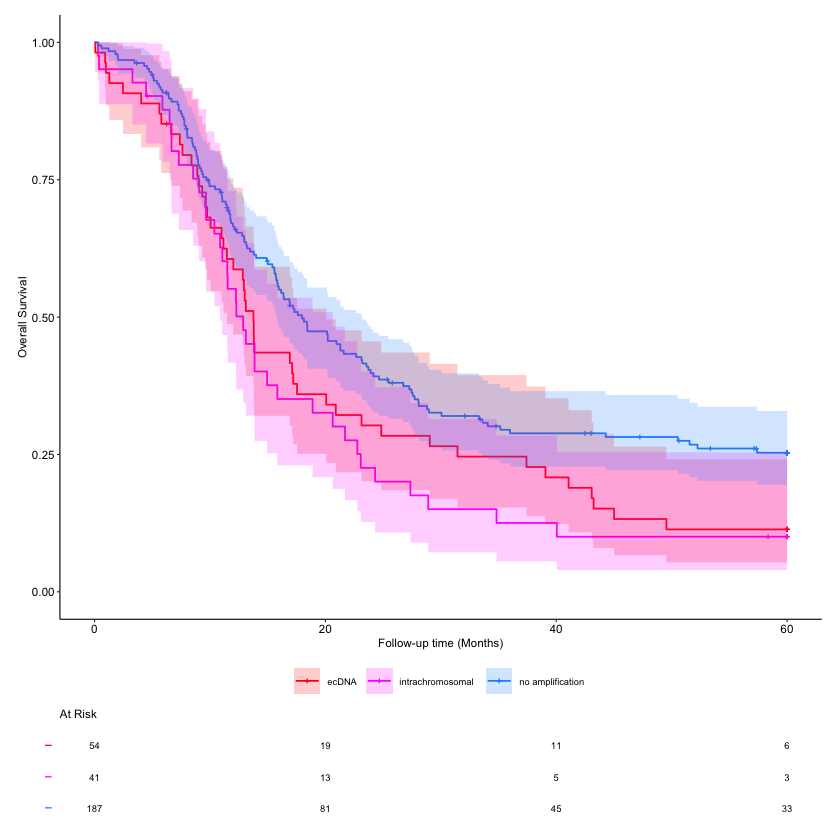

In [8]:
# KM by ecDNA status of tumor types with at least 1 sample with ecDNA, censored at 5 years
class_map <- c("ecDNA" = "ecDNA",
               "BFB" = "intrachromosomal",
               "Complex noncyclic" = "intrachromosomal",
               "Linear" = "intrachromosomal"
)
dd2 <- load_survival_data("../data/Supplementary Tables 12_1_24.xlsx") %>%
  mutate(amplicon_class = recode(amplicon_class, !!!class_map)) %>%
  group_by(cancer_type) %>%
  filter(str_detect(cancer_type, "HGG")) %>%
  filter(any(amplicon_class == 'ecDNA')) %>%
  ungroup()
dd2$cancer_type <- droplevels(dd2$cancer_type) # drop unused levels
dd2$cancer_type %>% unique() # print remaining levels

formula = Surv(OS_months_5y, OS_status_5y) ~ amplicon_class
km = survfit2(formula=formula, data = dd2 )
#km_plot(km, "km_class_subset_5year")
km_plot(km)
logrank <- pairwise_survdiff(formula,dd2,p.adjust.method="BH",rho=0)
logrank

# Cox regressions

We include tumor types which satisfy the following:
- At least 10 patients
- At least one death
- At least one ecDNA

In [18]:
dd3 <-load_survival_data("../data/Supplementary Tables 12_1_24.xlsx") %>%
  group_by(cancer_type) %>%
  filter(any(amplicon_class == 'ecDNA')) %>%
  filter(n() >= 10) %>%
  ungroup()
dim(dd3)
dd3$cancer_type %>% unique()
dd3$cancer_type <- droplevels(dd3$cancer_type)

dd3 %>% group_by(ecDNA_status, cancer_type) %>%
  summarise(n=n())%>%
  spread(cancer_type, n)
m1_unstrat <- coxph(Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + cancer_type, data = dd3)
m1_unstrat
#adding sex to the cox regression
m3 <- coxph(Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + age_at_diagnosis, data = dd3)
m3
#adding age at diagnosis to the cox regression
m4 <- coxph(Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + cancer_type + sex + age_at_diagnosis, data = dd3)
m4
# Check proportionality assumption
coxZph <-cox.zph(m1_unstrat) 
print("coxZph: ")
print(coxZph)

#inline forest plot for cox regression
m4 %>% 
   tbl_regression(
      exponentiate = TRUE,
      pvalue_fun = function(x) style_pvalue(x, digits = 2) 
   ) %>% 
   add_inline_forest_plot( 
      spec_pointrange.args = list(
         vline = 1,
         xlim = c(0, 10)
      )
   )


[1] 1849   12

[1] LGG  GCT  EPN  MBL  CPG  HGG  PNST MEL  CPT  EMBT SARC PINT NBL  RMS  OST 
[16] RBL  WLM 
43 Levels: ACC ATRT BENG BTNOS CARC CHDM CNSL CPG CPT DSRCT EBVT EMBT ... WLM

`summarise()` has grouped output by 'ecDNA_status'. You can override using the
`.groups` argument.


ecDNA_status,CPG,CPT,EMBT,EPN,GCT,HGG,LGG,MBL,MEL,NBL,OST,PINT,PNST,RBL,RMS,SARC,WLM
<fct>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ecDNA-,76,38,13,187,33,228,441,376,11,49,28,17,47,23,22,32,24
ecDNA+,1,1,3,2,2,54,1,74,1,12,25,1,1,6,14,5,1


Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  14 ; coefficient may be infinite. ”


Call:
coxph(formula = Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + 
    cancer_type, data = dd3)

                         coef  exp(coef)   se(coef)      z        p
ecDNA_statusecDNA+  5.740e-01  1.775e+00  1.196e-01  4.801 1.58e-06
cancer_typeCPT      7.388e-01  2.093e+00  7.072e-01  1.045 0.296152
cancer_typeEMBT     1.959e+00  7.090e+00  6.714e-01  2.917 0.003529
cancer_typeEPN      6.521e-01  1.920e+00  5.456e-01  1.195 0.231991
cancer_typeGCT      2.925e-02  1.030e+00  8.660e-01  0.034 0.973054
cancer_typeHGG      3.124e+00  2.273e+01  5.058e-01  6.175 6.60e-10
cancer_typeLGG     -1.207e+00  2.990e-01  6.268e-01 -1.926 0.054053
cancer_typeMBL      1.261e+00  3.529e+00  5.121e-01  2.463 0.013792
cancer_typeMEL      2.296e+00  9.934e+00  6.455e-01  3.557 0.000375
cancer_typeNBL      8.827e-01  2.417e+00  5.923e-01  1.490 0.136118
cancer_typeOST      1.537e+00  4.652e+00  5.537e-01  2.776 0.005498
cancer_typePINT     1.382e+00  3.985e+00  7.638e-01  1.810 0.070318
cancer_typePN

Call:
coxph(formula = Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + 
    age_at_diagnosis, data = dd3)

                         coef  exp(coef)   se(coef)      z      p
ecDNA_statusecDNA+  1.162e+00  3.197e+00  1.185e-01  9.806 <2e-16
age_at_diagnosis   -2.919e-06  1.000e+00  2.206e-05 -0.132  0.895

Likelihood ratio test=77.15  on 2 df, p=< 2.2e-16
n= 1801, number of events= 391 
   (48 observations deleted due to missingness)

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  14 ; coefficient may be infinite. ”


Call:
coxph(formula = Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + 
    cancer_type + sex + age_at_diagnosis, data = dd3)

                         coef  exp(coef)   se(coef)      z        p
ecDNA_statusecDNA+  6.553e-01  1.926e+00  1.244e-01  5.269 1.37e-07
cancer_typeCPT      8.420e-01  2.321e+00  7.646e-01  1.101  0.27078
cancer_typeEMBT     2.105e+00  8.209e+00  7.648e-01  2.753  0.00591
cancer_typeEPN      8.405e-01  2.318e+00  6.175e-01  1.361  0.17349
cancer_typeGCT      2.933e-01  1.341e+00  9.129e-01  0.321  0.74796
cancer_typeHGG      3.452e+00  3.156e+01  5.826e-01  5.925 3.13e-09
cancer_typeLGG     -9.375e-01  3.916e-01  6.901e-01 -1.358  0.17433
cancer_typeMBL      1.339e+00  3.814e+00  5.893e-01  2.271  0.02312
cancer_typeMEL      2.605e+00  1.353e+01  7.072e-01  3.684  0.00023
cancer_typeNBL      7.896e-01  2.202e+00  6.795e-01  1.162  0.24526
cancer_typeOST      2.058e+00  7.830e+00  6.495e-01  3.169  0.00153
cancer_typePINT     1.576e+00  4.837e+00  8.167e-01  1.9

[1] "coxZph: "
               chisq df    p
ecDNA_status  0.0156  1 0.90
cancer_type  22.7964 16 0.12
GLOBAL       22.8020 17 0.16


ERROR: Error in add_inline_forest_plot(., spec_pointrange.args = list(vline = 1, : could not find function "add_inline_forest_plot"


In [10]:
#The `cox.zph()` function tests the proportionality assumption. The result is borderline, suggesting that this 
#assumption may be violated w.r.t. the cancer_type variable. 
#Therefore, we perform Cox regression w.r.t. ecDNA, stratifying by cancer_type. The result is the unchanged.

m1 <- coxph(Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + strata(sex), data = dd3)
m1
# Check proportionality assumption
coxZph <-cox.zph(m1) 
print("coxZph: ")
print(coxZph)


Call:
coxph(formula = Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + 
    strata(sex), data = dd3)

                     coef exp(coef) se(coef)     z      p
ecDNA_statusecDNA+ 1.1588    3.1863   0.1163 9.961 <2e-16

Likelihood ratio test=80.17  on 1 df, p=< 2.2e-16
n= 1807, number of events= 393 
   (42 observations deleted due to missingness)

[1] "coxZph: "
              chisq df    p
ecDNA_status 0.0331  1 0.86
GLOBAL       0.0331  1 0.86


# Survival of H3K27 mutant HGG.
Cox analysis: TP53 mutant is really bad for your prognosis, ecDNA doesn't matter.

[1] 13

Call:
coxph(formula = formula, data = dd4)

                       coef exp(coef) se(coef)      z       p
ecDNA_statusecDNA+ -0.02864   0.97177  0.23153 -0.124 0.90156
TP53_mutantTRUE     0.52093   1.68360  0.19890  2.619 0.00882

Likelihood ratio test=7.02  on 2 df, p=0.02993
n= 122, number of events= 117 

[1] "coxZph: "
             chisq df    p
ecDNA_status  1.65  1 0.20
TP53_mutant   1.19  1 0.28
GLOBAL        2.46  2 0.29


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”


Call:
survdiff(formula = formula, data = dd4)

                     N Observed Expected (O-E)^2/E (O-E)^2/V
ecDNA_status=ecDNA- 97       92     93.7    0.0291     0.149
ecDNA_status=ecDNA+ 25       25     23.3    0.1169     0.149

 Chisq= 0.1  on 1 degrees of freedom, p= 0.7 

Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”


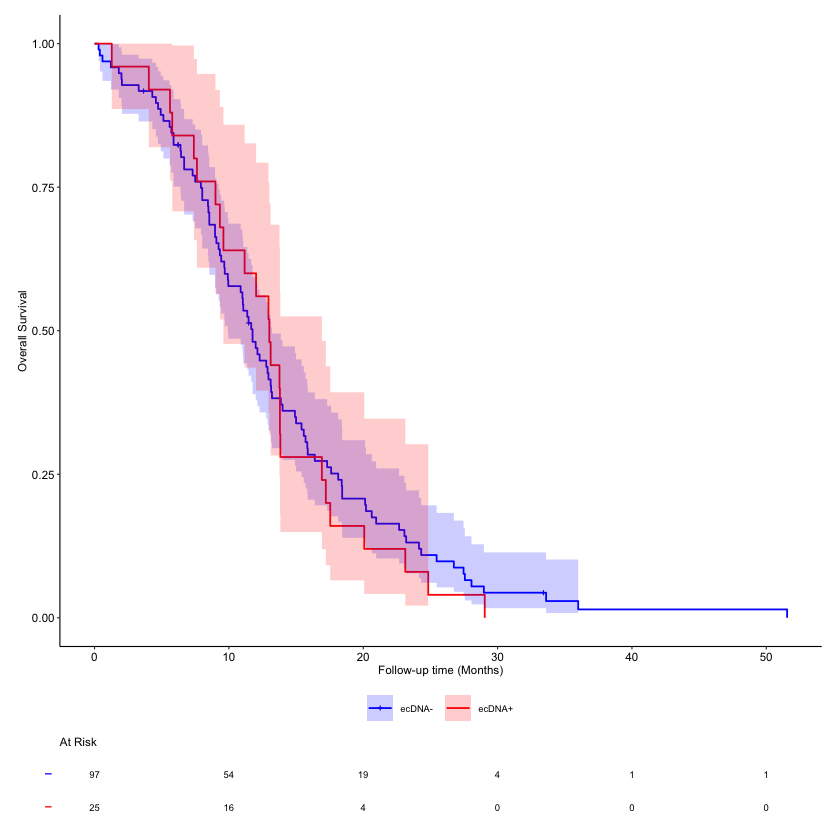

Call:
survdiff(formula = formula, data = dd4)

                   N Observed Expected (O-E)^2/E (O-E)^2/V
TP53_mutant=FALSE 64       59     72.5      2.51      7.13
TP53_mutant=TRUE  58       58     44.5      4.09      7.13

 Chisq= 7.1  on 1 degrees of freedom, p= 0.008 

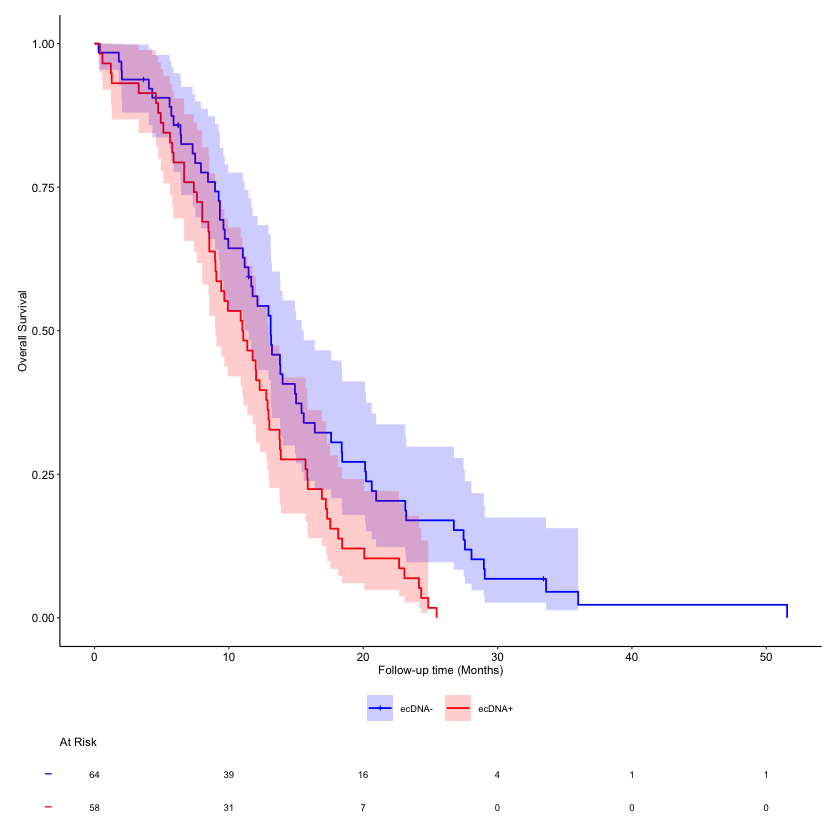

In [11]:
dd4 <- load_survival_data("../data/Supplementary Tables 12_1_24.xlsx") %>%
  filter(str_detect(cancer_subclass, "K27")) %>%
  mutate(TP53_mutant = ifelse(str_detect(cancer_subclass, "TP53"), TRUE, FALSE))

length(dd4)

formula <- Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + TP53_mutant
m2 <- coxph(formula = formula, data = dd4)
m2
# Check proportionality assumption
coxZph <-cox.zph(m2) 
print("coxZph: ")
print(coxZph)

formula <- Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status
km <- survfit2(formula=formula, data=dd4)
km_plot(km)
#km_plot(km, "km_surv_all_5year")
logrank <- survdiff(formula,dd4)
logrank

formula <- Surv(OS_months_5y, OS_status_5y) ~ TP53_mutant
km <- survfit2(formula=formula, data=dd4)
km_plot(km)
#km_plot(km, "km_surv_all_5year")
logrank <- survdiff(formula,dd4)
logrank


# Survival of subtypes

In [12]:
dd5 <- load_survival_data("../data/Supplementary Tables 12_1_24.xlsx") %>%
  filter(str_detect(cancer_type, "HGG"))

length(dd5)

formula <- Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status + cancer_subclass
m2 <- coxph(formula = formula, data = dd5)
m2
# Check proportionality assumption
coxZph <-cox.zph(m2) 
print("coxZph: ")
print(coxZph)

km <- survfit2(formula=formula, data=dd5)
km_plot(km)
#km_plot(km, "km_surv_all_5year")
logrank <- survdiff(formula,dd5)
logrank

[1] 12

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  15 ; coefficient may be infinite. ”


Call:
coxph(formula = formula, data = dd5)

                                    coef  exp(coef)   se(coef)      z      p
ecDNA_statusecDNA+             1.398e-01  1.150e+00  1.732e-01  0.807 0.4194
cancer_subclassDHG_H3G34_TP53  4.772e-01  1.612e+00  8.169e-01  0.584 0.5591
cancer_subclassDMG_H3K27       1.084e+00  2.955e+00  5.974e-01  1.814 0.0697
cancer_subclassDMG_H3K27_TP53  1.491e+00  4.442e+00  5.989e-01  2.490 0.0128
cancer_subclassHGG_H3G34       1.514e+00  4.544e+00  1.160e+00  1.305 0.1917
cancer_subclassHGG_H3K27       1.420e+00  4.137e+00  6.598e-01  2.152 0.0314
cancer_subclassHGG_H3WT       -1.321e-01  8.762e-01  6.061e-01 -0.218 0.8275
cancer_subclassHGG_H3WT_TP53   4.151e-01  1.515e+00  6.271e-01  0.662 0.5080
cancer_subclassHGG_IDH_TP53   -1.279e+00  2.782e-01  9.164e-01 -1.396 0.1628
cancer_subclassHGGNOS          2.794e-02  1.028e+00  6.039e-01  0.046 0.9631
cancer_subclassHGNET          -8.010e-01  4.489e-01  1.156e+00 -0.693 0.4884
cancer_subclassIHG_ALK          

[1] "coxZph: "
                 chisq df      p
ecDNA_status     0.946  1 0.3306
cancer_subclass 34.043 13 0.0012
GLOBAL          34.611 14 0.0017


ERROR: [1m[33mError[39m in `palette()`:[22m
[1m[22m[33m![39m Insufficient values in manual scale. 22 needed but only 1 provided.


[1] 12

Call:
coxph(formula = formula, data = dd5)

                     coef exp(coef) se(coef)     z     p
ecDNA_statusecDNA+ 0.2035    1.2257   0.1678 1.213 0.225

Likelihood ratio test=1.42  on 1 df, p=0.2339
n= 265, number of events= 203 

[1] "coxZph: "
             chisq df    p
ecDNA_status  0.22  1 0.64
GLOBAL        0.22  1 0.64


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <e2>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <96>”
Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on '▬' in 'mbcsToSbcs': dot substituted for <ac>”


Call:
survdiff(formula = formula, data = dd5)

                      N Observed Expected (O-E)^2/E (O-E)^2/V
ecDNA_status=ecDNA- 212      157    163.8     0.284      1.47
ecDNA_status=ecDNA+  53       46     39.2     1.187      1.47

 Chisq= 1.5  on 1 degrees of freedom, p= 0.2 

ERROR: [1m[33mError[39m in `palette()`:[22m
[1m[22m[33m![39m Insufficient values in manual scale. 8 needed but only 1 provided.


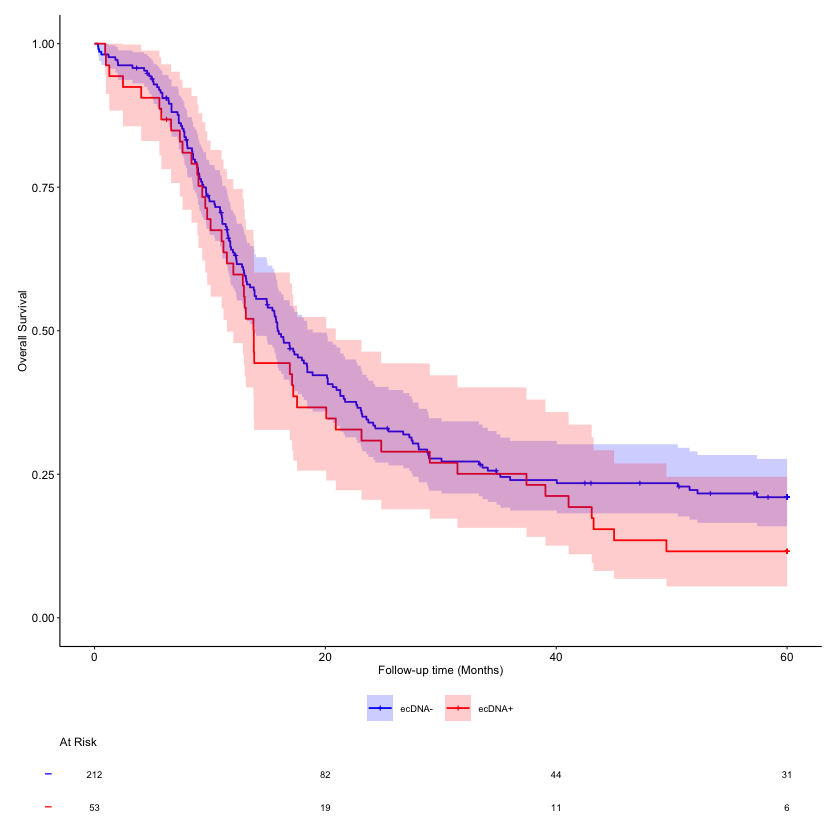

In [13]:
dd5 <- load_survival_data("../data/Supplementary Tables 12_1_24.xlsx") %>%
  filter(str_detect(cancer_subclass, "HGG") | str_detect(cancer_subclass, "DMG"))

length(dd5)

formula <- Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status
m2 <- coxph(formula = formula, data = dd5)
m2
# Check proportionality assumption
coxZph <-cox.zph(m2) 
print("coxZph: ")
print(coxZph)

formula <- Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status
km <- survfit2(formula=formula, data=dd5)
km_plot(km)
#km_plot(km, "km_surv_all_5year")
logrank <- survdiff(formula,dd5)
logrank

formula <- Surv(OS_months_5y, OS_status_5y) ~ cancer_subclass
km <- survfit2(formula=formula, data=dd5)
km_plot(km)
#km_plot(km, "km_surv_all_5year")
logrank <- survdiff(formula,dd5)
logrank


In [ ]:
# Relapsed analysis

In [59]:
dd6 <- load_survival_data("../data/Supplementary Tables 10_30_24.xlsx", sheet="2. Biosamples") %>%
  filter(str_detect(cancer_subclass, "HGG") | str_detect(cancer_subclass, "DMG"))

length(dd5)

formula <- Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status
m2 <- coxph(formula = formula, data = dd5)
m2
# Check proportionality assumption
coxZph <-cox.zph(m2) 
print("coxZph: ")
print(coxZph)

formula <- Surv(OS_months_5y, OS_status_5y) ~ ecDNA_status
km <- survfit2(formula=formula, data=dd5)
km_plot(km)
#km_plot(km, "km_surv_all_5year")
logrank <- survdiff(formula,dd5)
logrank

formula <- Surv(OS_months_5y, OS_status_5y) ~ cancer_subclass
km <- survfit2(formula=formula, data=dd5)
km_plot(km)
#km_plot(km, "km_surv_all_5year")
logrank <- survdiff(formula,dd5)
logrank


ERROR: Error in load_survival_data("../data/Supplementary Tables 10_30_24.xlsx", : unused argument (sheet = "2. Biosamples")
